# Predictive models

This notebook includes many different approaches to predictive models.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [2]:
import sys
sys.path.append('../src/')
import aposch_functions as aposch
import predictive_model_helpers as pmh

In [27]:
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR


#### Get datasets

In [4]:
# read in data
data2019 = pd.read_csv('../data/2019_RAW_APC_Data.csv.gz')

# get df04
df04 = aposch.clean_data(data2019)

# split into test/train sets
df04_train, df04_test = train_test_split(df04,
                                         test_size=0.2,
                                         random_state=19)

# get cycle-related features
df05_train = aposch.do_cycles_processing(df04_train)

In [5]:
df = df05_train

### Create datasets with X in the format for "predict next"

Need to think about this.

Goal: use previous passenger counts to predict the current passenger count.

Q: Should I train one model using all stadirs at once? Or, should I train a different model for each stadir?

Q: What is the time granularity?
- Q: What is the best time granularity that I even have?
  - For a given stadir, look at what kind of granularity/resolution do we have?
  - For a given stadir, how many observations do we have *per hour*?

In [6]:
# For a given stadir, how many observations do we have *per hour*?
# Ans: we have an average of 5 per hour
agg = df04.groupby(['stadir_ID','DOY','Hour'])['passwithin'].count()
agg.median()

5.0

For a first trial, focus only on Pioneer Square going Southbound. Use only the observations of passwithin of other trains that passed through in the short time before the train of interest arrives.

Gather info about Pioneer.

Note that Pioneer is sta_ID 12, so Pioneer Southbound is stadir_ID 1211.

In [7]:
pioneer = df.loc[df['stadir_ID']==1211,
       ['railcar ID','DOY','stop arrival time','passwithin']].sort_values('stop arrival time')

In [8]:
pioneer_ts = pioneer.set_index('stop arrival time', drop=True)['passwithin']

In [9]:
def get_features_8x15min(pioneer, pioneer_ts, obs):
    '''
    Expects a dataframe of all passwithin observations, a Series of all the timestamps, and a row you're working with
    '''
    timestamp = pioneer.at[obs,'stop arrival time']
    idx_start = timestamp - pd.DateOffset(minutes=150)
    idx_end = timestamp - pd.DateOffset(minutes=30)
    period_idx = pd.period_range(idx_start, freq='15min', periods=8)

    # get FMP masks
    FMP_masks = []  # FMP is a 15-minute period
    for i in range(8):
        boolean_membership = (pioneer_ts.index >= period_idx[i].start_time) & (pioneer_ts.index < period_idx[i].end_time)
        FMP_masks.append(boolean_membership)
    
    # calculate mean for each FMP and add it to the pioneer dataframe
    for i, FMP_mask in enumerate(FMP_masks):
        meanpass = pioneer.loc[FMP_mask,'passwithin'].mean()
        pioneer.at[obs,'FMP_'+str(i)] = meanpass
        
    return pioneer

In [10]:
pioneer = get_features_8x15min(pioneer, pioneer_ts, 1318946)

In [11]:
counter = 0
for obs in pioneer.index:
    pioneer = get_features_8x15min(pioneer, pioneer_ts, obs)
    counter += 1
    if counter % 1000 == 0:
        print('did',counter,'rows so far')

did 1000 rows so far
did 2000 rows so far
did 3000 rows so far
did 4000 rows so far
did 5000 rows so far
did 6000 rows so far
did 7000 rows so far
did 8000 rows so far
did 9000 rows so far
did 10000 rows so far
did 11000 rows so far
did 12000 rows so far
did 13000 rows so far
did 14000 rows so far
did 15000 rows so far
did 16000 rows so far
did 17000 rows so far
did 18000 rows so far
did 19000 rows so far
did 20000 rows so far
did 21000 rows so far
did 22000 rows so far
did 23000 rows so far
did 24000 rows so far
did 25000 rows so far
did 26000 rows so far
did 27000 rows so far
did 28000 rows so far
did 29000 rows so far


In [12]:
X, y = pioneer.loc[:,'FMP_0':'FMP_7'], pioneer.loc[:,'passwithin']
tridx = X.index.intersection(df04_train.index)
X_train, y_train = X.loc[tridx,:], y[tridx]

In [13]:
X.isna().sum(axis=0) / X.count(axis=0)

FMP_0    0.614893
FMP_1    0.592215
FMP_2    0.329781
FMP_3    0.622891
FMP_4    0.513809
FMP_5    0.616732
FMP_6    0.472980
FMP_7    0.570330
dtype: float64

Need to get rid of rows that have a lot of NaNs.

In [14]:
filt = X_train.isna().sum(axis=1) <= 4 # rows that have at most 4 NaNs (i.e. at least 4 real datapoints)

X_train2 = X_train.loc[filt,:]
y_train2 = y_train[filt]

print(len(y_train2))

print(len(y_train))

print(len(y_train2)/len(y_train))

print('Before linear interpolation, X_train2 had this many NaNs:')
print(X_train2.isna().sum())
X_train3 = X_train2.interpolate(axis=1, method='linear')

print('After linear interpolation, X_train3 had this many NaNs:')
print(X_train3.isna().sum())

print('''Note that all the remaining NaNs were in the earliest four Fifteen-Minute Periods.
All the observations that had remaining NaNs are shown in a visual below. We see that some are in the 7am and 8am hours
as I expected, but there are plenty more throughout the day. I don't know why this is.

Theory: To get to a low-observation-density time of day, you have to go back in time about two hours before the
target observation...

I still don't fully understand this. I don't understand why we _never_ see two NaNs in a
row in the 60-30 minutes-before window.''')
obs_w_early_na = X_train3.isna().sum(axis=1) > 0
print('Note that this many observations got NaNs filled with zeros:', sum(obs_w_early_na))

X_train4 = X_train3.fillna(0)

25801
29819
0.8652536973070861
Before linear interpolation, X_train2 had this many NaNs:
FMP_0    7843
FMP_1    7768
FMP_2    4434
FMP_3    8080
FMP_4    7001
FMP_5    8350
FMP_6    6976
FMP_7    8086
dtype: int64
After linear interpolation, X_train3 had this many NaNs:
FMP_0    7843
FMP_1    2303
FMP_2     353
FMP_3      80
FMP_4       0
FMP_5       0
FMP_6       0
FMP_7       0
dtype: int64
Note that all the remaining NaNs were in the earliest four Fifteen-Minute Periods.
All the observations that had remaining NaNs are shown in a visual below. We see that some are in the 7am and 8am hours
as I expected, but there are plenty more throughout the day. I don't know why this is.

Theory: To get to a low-observation-density time of day, you have to go back in time about two hours before the
target observation...

I still don't fully understand this. I don't understand why we _never_ see two NaNs in a
row in the 60-30 minutes-before window.
Note that this many observations got NaNs filled 

In [15]:
early_na = pioneer.index.isin(X_train3.loc[obs_w_early_na].index)

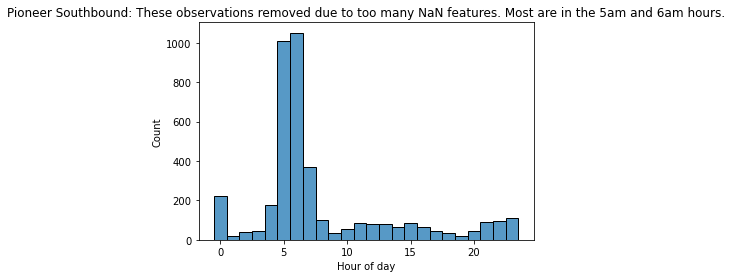

In [39]:
# look into the observations that were first-pass filtered out:
# DO a KDE using stop arrival time
sns.histplot(x=pioneer.loc[~filt,'stop arrival time'].dt.hour, discrete=True)
plt.title('Pioneer Southbound: These observations removed due to too many NaN features. Most are in the 5am and 6am hours.')
plt.xlabel('Hour of day')
plt.savefig('../images/PM_removed_obs.png', bbox_inches='tight')

Text(0.5, 1.0, 'Hour of targets with two NaN features in a row, did not get interpolated. Those NaNs got filled as 0.')

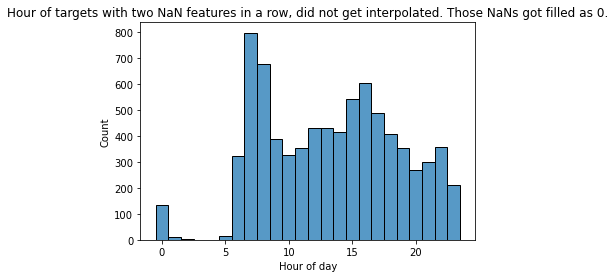

In [17]:
# look into the observations that were first-pass filtered out:
# DO a KDE using stop arrival time
sns.histplot(x=pioneer.loc[early_na,'stop arrival time'].dt.hour,discrete=True)
plt.xlabel('Hour of day')
plt.title('Hour of targets with two NaN features in a row, did not get interpolated. Those NaNs got filled as 0.')

Text(0.5, 0, 'Hour of day')

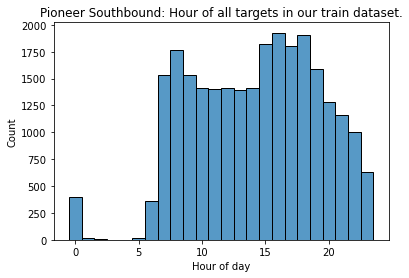

In [18]:
# look into the observations that were first-pass filtered out:
# DO a KDE using stop arrival time
sns.histplot(x=pioneer.loc[X_train4.index,'stop arrival time'].dt.hour,
             discrete=True
             #hue=pioneer.loc[early_na,:]
            )
plt.title('Pioneer Southbound: Hour of all targets in our train dataset.')
plt.xlabel('Hour of day')

We see that this covers 87% of observations. Great. 

Once we removed the really bad rows, we used linear interpolation to fill in NaNs in the rows that were still salvageable.

Upshot: starting with around 30000 observations, we removed 4000 due to too many NaN features - vast majority were 5am or 6am observations - understandable why so many NaN features. Out of the 26000 that we're using in our training set, 18000 were able to get all their NaNs filled by interpolation, and 8000 had some set of consecutive FMPs that were NaNs filled as 0s.


Picking up a thread again - the observations with 5 or more NaN features. How crowded were they?

pioneer.loc[~filt,'passwithin']

In [21]:
pioneer.loc[~filt,'passwithin'].mean()

28.112742658038826

In [22]:
pioneer.loc[~filt,'passwithin'].gt(74).sum()

226

So, out of the ones we removed due to having too many NaNs, about 5% of them were Crowded (>74).

## Running the predictive models

In [24]:
forest01 = RandomForestRegressor(n_estimators=500,random_state=19)

scores = pmh.cv_readout_r_to_c(forest01,
                    X_train4,
                    y_train2)
scores

Performing 5-fold cross-validation...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Aggregating the scores...
[[18454  1532]
 [ 1890  3925]]
                mean       std
precision   0.717337  0.020632
recall      0.675077  0.008186
f1          0.695451  0.012377
rmse       25.715303  1.205023


In [20]:
linreg01 = LinearRegression()

scores = pmh.cv_readout_r_to_c(linreg01,
                    X_train4,
                    y_train2)
scores

Performing 5-fold cross-validation...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Aggregating the scores...
[[18461  1525]
 [ 2284  3531]]
               mean       std
precision  0.696588  0.017394
recall      0.60648  0.014969
f1         0.648282  0.012994
rmse       27.28128  1.608785


In [25]:
extrees01 = ExtraTreesRegressor(n_estimators=500,random_state=19)

scores = pmh.cv_readout_r_to_c(extrees01,
                    X_train4,
                    y_train2)
scores

Performing 5-fold cross-validation...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Aggregating the scores...
[[18428  1558]
 [ 1875  3940]]
                mean       std
precision   0.714869   0.01935
recall       0.67775  0.008592
f1          0.695681  0.011157
rmse       25.559767  1.158628


In [36]:
forest02 = RandomForestRegressor(n_estimators=500,random_state=19)

scores = pmh.cv_readout_r_to_c(forest02,
                    X_train4.loc[:,'FMP_4':'FMP_7'],
                    y_train2)
scores

Performing 5-fold cross-validation...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Aggregating the scores...
[[18071  1915]
 [ 2069  3746]]
                mean       std
precision   0.659957   0.02067
recall      0.644481  0.007732
f1          0.651951  0.011213
rmse       27.872832  1.412147


In [37]:
linreg02 = LinearRegression()

scores = pmh.cv_readout_r_to_c(linreg02,
                    X_train4.loc[:,'FMP_4':'FMP_7'],
                    y_train2)
scores

Performing 5-fold cross-validation...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Aggregating the scores...
[[18429  1557]
 [ 2313  3502]]
                mean       std
precision   0.690429  0.016188
recall      0.601815  0.015215
f1          0.642962  0.012916
rmse       27.446768  1.610666


In [38]:
extrees01 = ExtraTreesRegressor(n_estimators=500,random_state=19)

scores = pmh.cv_readout_r_to_c(extrees01,
                    X_train4.loc[:,'FMP_4':'FMP_7'],
                    y_train2)
scores

Performing 5-fold cross-validation...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Aggregating the scores...
[[17973  2013]
 [ 2037  3778]]
                mean       std
precision      0.651  0.018999
recall      0.649494  0.009038
f1          0.650157  0.012786
rmse       28.176415  1.419083


### SVM is not working and I don't know why

In [35]:
std = np.std(X_train4)
svr01 = SVR(C=std, epsilon=0.2*std)
svr01.fit(X_train4.astype(float), y_train2.astype(float))

TypeError: cannot convert the series to <class 'float'>

In [28]:
std = np.std(X_train4)
svr01 = SVR(C=std, epsilon=0.2*std)

scores = pmh.cv_readout_r_to_c(svr01,
                    X_train4,
                    y_train2)
scores

Performing 5-fold cross-validation...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\augus\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\augus\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\augus\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 315, in _dense_fit
    ) = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", li

NotFittedError: All estimators failed to fit

Describe this well!!

### Classic readout function

- does 5-fold CV and prints confusion matrix, as well as precision, recall, f1, and the standard error of each score.

### Create datasets

In [ ]:
feats03 = ['Hour','DOW','Month','station name','next station']

In [ ]:
feats = feats03

What proportion of the dataset is the clear_obs versus the borderline observations?

### Predictive models using traditional dataset

In [ ]:
logi08 = LogisticRegression(class_weight='balanced', solver='saga', max_iter=500)

X_train, y_train = pmh.create_train_datasets(df05_train, feats=feats03, onehot=True, remove_borderline=False,
                                         sample_size=100000, problem='classification')

scores = pmh.cv_readout(logi08,
                    X_train,
                    y_train)
scores

Random Forest actually works better in some ways:

In [ ]:
forest01 = RandomForestClassifier()

X_train, y_train = create_train_datasets(feats=feats03, onehot=True, remove_borderline=False,
                                         sample_size=100000, problem='classification')

scores = cv_readout(forest01,
                    X_train,
                    y_train)
scores

Finally, here's Random Forest with `class_weight='balanced'`. It has better recall but worse precision than the first RF:

In [ ]:
forest02 = RandomForestClassifier(class_weight='balanced')

X_train, y_train = create_train_datasets(feats=feats03, onehot=True, remove_borderline=False,
                                         sample_size=100000, problem='classification')

scores = cv_readout(forest02,
                    X_train,
                    y_train)
scores

Linear Regression almost never guesses values >74, so it gets dismal recall:

In [ ]:
linreg01 = LinearRegression()

X_train, y_train = create_train_datasets(feats=feats03, onehot=True, remove_borderline=False,
                                         sample_size=100000, problem='regression')

scores = cv_readout_r_to_c(linreg01,
                    X_train,
                    y_train)
scores

TODO: Linear Regression scored with RMSE and plotted - this exercise will teach us something about our problem.

### Predictive models on clearly separable dataset

Go back to Models_Aug02.ipynb and re-paste if I want this.

### Explaining why Linear Regression may perform poorly

- What types of conditions harbor Crowded observations, and what types of conditions harbor NonCrowded observations?
- This analysis shows that, in order to successfully warn people of Crowded situations, some class imbalance approach is required.

In [ ]:
# WHat are the conditions in which we see the most Crowded observations?
crowded_conditions = df04_train.groupby(['Hour','DOW','Month','stadir_ID'])['Crowded'].mean().sort_values().tail(3100)
crowded_conditions

There are 58000 conditions. Only about 3000 conditions have a greater than 50% chance of being Crowded. 

In [ ]:
obscount = df04_train.groupby(['Hour','DOW','Month','stadir_ID'])['Crowded'].count()

obscount_cwd_conditions = df04_train.groupby(['Hour','DOW','Month','stadir_ID'])['Crowded'].count()[crowded_conditions.index]

print('There are',
      sum(obscount_cwd_conditions), 'crowded observations that happen in crowded-majority conditions.' )

In [ ]:
print('Recall that there are', df04_train['Crowded'].sum(), 'crowded observations.')

In [ ]:
proportion = sum(obscount_cwd_conditions)/df04_train['Crowded'].sum()
print('Therefore, only', proportion, 'of Crowded observations are ~easy to classify as Crowded.')

In [ ]:
print('To get the rest of them, we need to address the class imbalance somehow.')